In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import geopandas as gpd
from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter

In [3]:
sys.path.insert(1,'../analysis/')
sys.path.insert(1,'../optimization/')

In [4]:
from results_plotting import *
import plant_optimization as pop

# Setup

## Directory Pointers

In [5]:
results_paths = '../../results/plant_optimization/final_results'

## Europe grid shapefile

In [6]:
europe_grid, europe_borders = load_base_maps()
europe_grid = europe_grid[['lat','lon','country','sea_node','geometry']]
merge_cols = list(europe_grid.columns)
merge_cols.remove('geometry')

## Plant assumptions

In [7]:
specs = pd.read_excel('../../data/plant_assumptions.xlsx',sheet_name='data',index_col=0)
specs_names = specs.index

## Results data

In [8]:
year = '2020'
data_2020 = pd.read_csv(os.path.join(results_paths,f'{year}.csv'))
data_2020_geo = gpd.GeoDataFrame(data_2020.drop(columns=['geometry'])).merge(europe_grid,on=merge_cols,how='left')
countries = data_2020.country.unique()

# Plots

# Costs

In [9]:
year=2020
costs_df = pd.read_csv(os.path.join(results_paths,f'{year}.csv'))

specs_temp = specs.copy()
specs_temp['value'] = specs_temp[f'value_{year}']
# If any specs are not specified for the given year, take the 2020 value
specs_temp.loc[specs_temp.value.isna(),'value'] = specs_temp.loc[specs_temp.value.isna(),'value_2020']

components = {'wind':['wind_capacity_MW',1e3],
              'PV':['PV_capacity_MW',1e3],
              'battery':['battery_capacity_MWh',1e3],
              'electrolyzer':['electrolyzer_capacity_MW',1e3],
              'CO2':['CO2_capture_tonph',8760],
              'H2stor':['H2stor_capacity_MWh',1e3],
              'CO2stor':['CO2stor_capacity_ton',1],
              'H2tL':['H2tL_capacity_MW',1e3],
              'heat':['boiler_capacity_MW',1e3]}
discount_rate = specs_temp.at['discount_rate',f'value']
plant_lifetime = specs_temp.at['lifetime',f'value']

for component in components.keys():
    costs_df[component+'_NPV'] = np.nan
    costs_df[f'{component}_verify_CAPEX'] = np.nan
costs_df['verify_NPV'] = np.nan
    
for idx,row in costs_df.iterrows():
    verify_NPV = 0
    verify_CAPEX = 0
    for component,value in components.items():
        if component == 'wind':
            if row['shore_designation'] == 'onshore':
                wind_class = row['wind_class']
                capex = specs_temp.at[f'{component}_{wind_class}_CAPEX',f'value']
                opex = specs_temp.at[f'{component}_{wind_class}_OPEX',f'value']
            elif row['shore_designation'] == 'offshore':
                platform_type = 'monopole' if row['shore_dist']<=60 else 'floating'
                capex = specs_temp.at[f'{component}_{platform_type}_CAPEX',f'value']
                opex = specs_temp.at[f'{component}_{platform_type}_OPEX',f'value']
        else:
            capex = specs_temp.at[f'{component}_CAPEX',f'value']
            opex = specs_temp.at[f'{component}_OPEX',f'value']
        component_lifetime = specs_temp.at[f'{component}_lifetime',f'value']
        capacity = row[value[0]]*value[1]
        component_capex = capex * capacity
        costs_df.loc[idx,f'{component}_verify_CAPEX'] = component_capex        
        verify_CAPEX += component_capex
        
        if component == 'electrolyzer':
            component_npv = pop.costs_NPV(capex=capex,opex=opex,discount_rate=discount_rate,plant_lifetime=plant_lifetime,component_lifetime=specs_temp.at['electrolyzer_stack_lifetime',f'value'],
                                          capacity=capacity,replacement_capex_fraction=specs_temp.at['electrolyzer_stack_CAPEX',f'value'])                
        else:
            component_npv = pop.costs_NPV(capex=capex,opex=opex,discount_rate=discount_rate,plant_lifetime=plant_lifetime,component_lifetime=component_lifetime,capacity=capacity,)
        costs_df.loc[idx,component+'_NPV'] = component_npv
        verify_NPV += component_npv
    costs_df.loc[idx,'verify_NPV'] = verify_NPV
    costs_df.loc[idx,'verify_CAPEX'] = verify_CAPEX
#     if idx == 0:
#         break

In [59]:
onshore_npv_cols = ['wind_NPV', 'electrolyzer_NPV', 'CO2_NPV', 'PV_NPV', 'H2stor_NPV', 'H2tL_NPV', 'battery_NPV', 'CO2stor_NPV', 'heat_NPV', 'verify_NPV']
offshore_npv_cols = ['wind_NPV', 'electrolyzer_NPV', 'H2stor_NPV', 'CO2_NPV', 'battery_NPV', 'H2tL_NPV', 'CO2stor_NPV', 'heat_NPV', 'verify_NPV']
colors = ['#264653','#2A9D8F','#C45544','#F4974B','#EDD363','#1D84B5','#BEB7DF','#0BC9CD','#D90368','#A4A0A9']
colormap = {x:colors[i] for i,x in enumerate(onshore_npv_cols)}

col_name_map = {
    'wind_NPV':'Wind', 
    'electrolyzer_NPV':'Electrolyzer',
    'CO2_NPV':'$CO_{2}$ Capture',
    'PV_NPV':'PV',
    'H2stor_NPV':'Hydrogen Storage',
    'H2tL_NPV':'$H_{2}tL$',
    'battery_NPV':'Battery',
    'CO2stor_NPV':'$CO_{2}$ Storage',
    'heat_NPV':'Heat',
    'verify_NPV':'Total'
}

In [60]:
share = costs_df.loc[costs_df['shore_designation']=='onshore',onshore_npv_cols]
for col in share.columns:
    share[col] = share[col]/share['verify_NPV']
share.describe()

,wind_NPV,electrolyzer_NPV,CO2_NPV,PV_NPV,H2stor_NPV,H2tL_NPV,battery_NPV,CO2stor_NPV,heat_NPV,verify_NPV
count,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.0
mean,0.340923,0.221585,0.163746,0.144698,0.097456,0.014462,0.008917,0.006480,0.001733,1.0
std,0.056922,0.018249,0.020906,0.063433,0.032651,0.002419,0.008120,0.002660,0.000285,0.0
min,-0.000000,0.108864,0.056716,0.003171,0.038938,0.003457,0.003389,0.001627,0.000644,1.0
25%,0.316688,0.212357,0.154569,0.100057,0.077342,0.013553,0.006027,0.004536,0.001632,1.0
50%,0.338275,0.220640,0.165169,0.148011,0.093010,0.014767,0.007097,0.005844,0.001737,1.0
75%,0.377712,0.233210,0.175864,0.183045,0.113455,0.015989,0.008724,0.007903,0.001853,1.0
max,0.482937,0.280640,0.215062,0.437326,0.435819,0.018966,0.092000,0.019765,0.012619,1.0


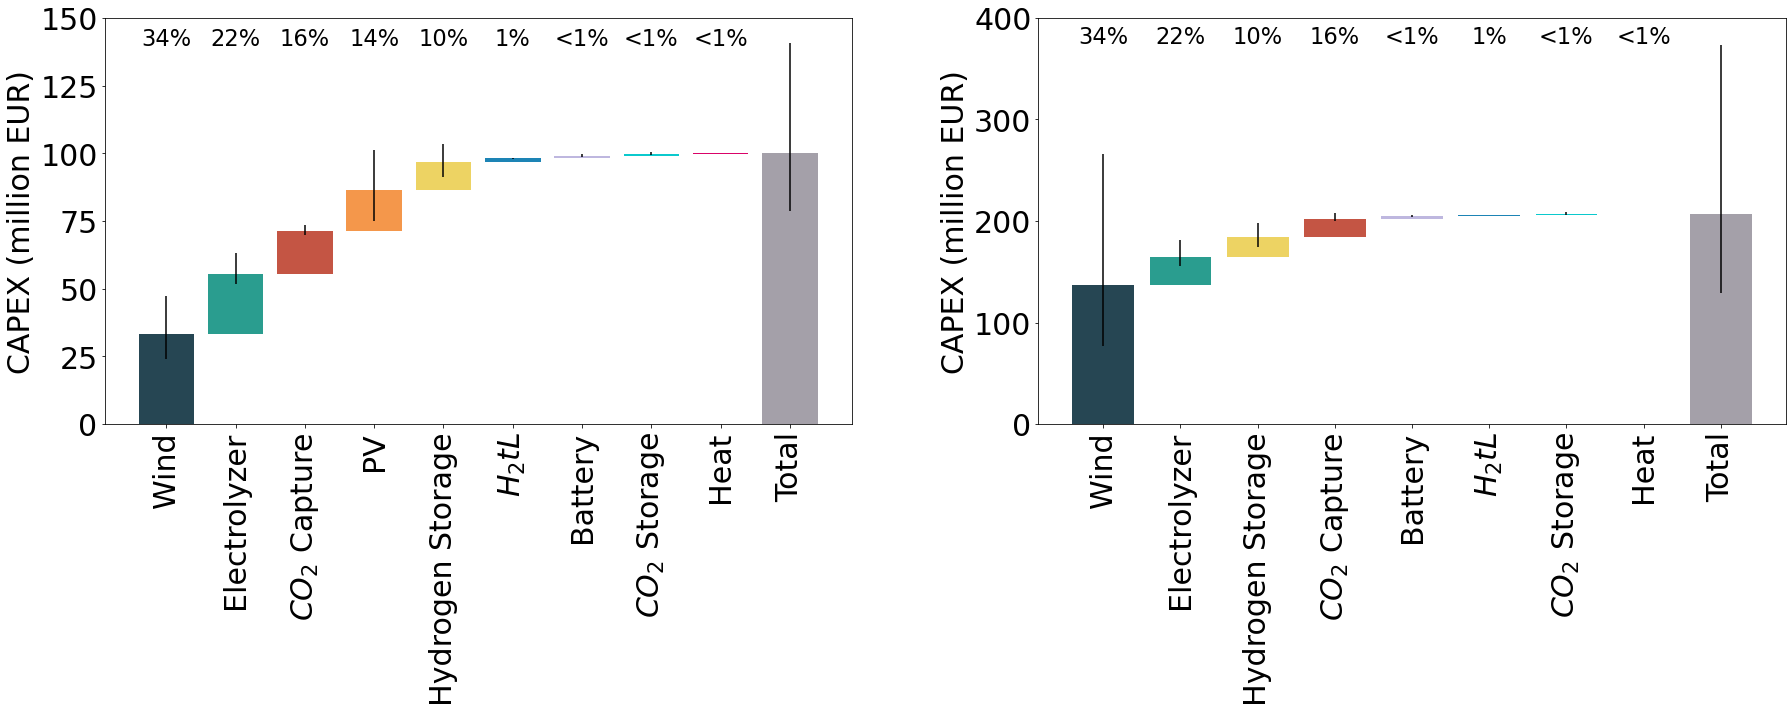

In [61]:
onshore_npv_summary = costs_df.loc[costs_df['shore_designation']=='onshore',onshore_npv_cols].describe(percentiles=[0.05,0.5,0.95]).T/1e6 # million EUR
onshore_npv_cumsum = onshore_npv_summary.cumsum()
onshore_npv_cumsum.iloc[-1] = onshore_npv_summary.iloc[-1]
onshore_npv_cumsum_mask = onshore_npv_cumsum.shift()
onshore_npv_cumsum_mask.iloc[-1] = 0

onshore_npv_share = costs_df.loc[costs_df['shore_designation']=='onshore',onshore_npv_cols]
for col in onshore_npv_share.columns:
    onshore_npv_share[col] = onshore_npv_share[col]/onshore_npv_share['verify_NPV']
onshore_npv_share = onshore_npv_share.describe().iloc[:,:-1].loc['mean']


fig,axes = plt.subplots(ncols=2, figsize=(25,10))
fontsize = 30

yerr1 = onshore_npv_summary['mean'] - onshore_npv_summary['5%']
yerr2 = onshore_npv_summary['95%'] - onshore_npv_summary['mean']
axes[0].bar(onshore_npv_cumsum.index.map(col_name_map), onshore_npv_cumsum['mean'], yerr=[yerr1,yerr2], color=onshore_npv_cumsum.index.map(colormap))
axes[0].bar(onshore_npv_cumsum_mask.index.map(col_name_map), onshore_npv_cumsum_mask['mean'], color='white')
for tick in axes[0].get_xticklabels():
    tick.set_rotation(90)
    
axes[0].set_ylim(0,150)
# axes[0].set_ylim(0,110)
axes[0].set_ylabel('CAPEX (million EUR)', fontsize=fontsize)
for i,comp_share in enumerate(onshore_npv_share):
    if comp_share<0.01:
        text = '<1%'
    else:
        text = f'{comp_share*100:.0f}%'
    axes[0].annotate(text, (i,140), fontsize=fontsize*0.75, ha='center')
axes[0].tick_params(labelsize=fontsize)


offshore_npv_summary = costs_df.loc[costs_df['shore_designation']=='offshore',offshore_npv_cols].describe(percentiles=[0.05,0.5,0.95]).T/1e6 # million EUR
offshore_npv_cumsum = offshore_npv_summary.cumsum()
offshore_npv_cumsum.iloc[-1] = offshore_npv_summary.iloc[-1]
offshore_npv_cumsum_mask = offshore_npv_cumsum.shift()
offshore_npv_cumsum_mask.iloc[-1] = 0

offshore_npv_share = costs_df.loc[costs_df['shore_designation']=='onshore',offshore_npv_cols]
for col in offshore_npv_share.columns:
    offshore_npv_share[col] = offshore_npv_share[col]/offshore_npv_share['verify_NPV']
offshore_npv_share = offshore_npv_share.describe().iloc[:,:-1].loc['mean']

    
yerr1 = offshore_npv_summary['mean'] - offshore_npv_summary['5%']
yerr2 = offshore_npv_summary['95%'] - offshore_npv_summary['mean']
axes[1].bar(offshore_npv_cumsum.index.map(col_name_map), offshore_npv_cumsum['mean'], yerr=[yerr1,yerr2], color=offshore_npv_cumsum.index.map(colormap))
axes[1].bar(offshore_npv_cumsum_mask.index.map(col_name_map), offshore_npv_cumsum_mask['mean'], color='white')
for ax in axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    
axes[1].set_ylim(0,400)
# axes[1].set_ylim(0,250)
axes[1].set_ylabel('CAPEX (million EUR)', fontsize=fontsize)
for i,comp_share in enumerate(offshore_npv_share):
    if comp_share<0.01:
        text = '<1%'
    else:
        text = f'{comp_share*100:.0f}%'
    axes[1].annotate(text, (i,375), fontsize=fontsize*0.75, ha='center')
axes[1].tick_params(labelsize=fontsize)

plt.tight_layout()
plt.subplots_adjust(hspace=0,wspace=0.25)

/opt/anaconda3/envs/EuroSAFs/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator


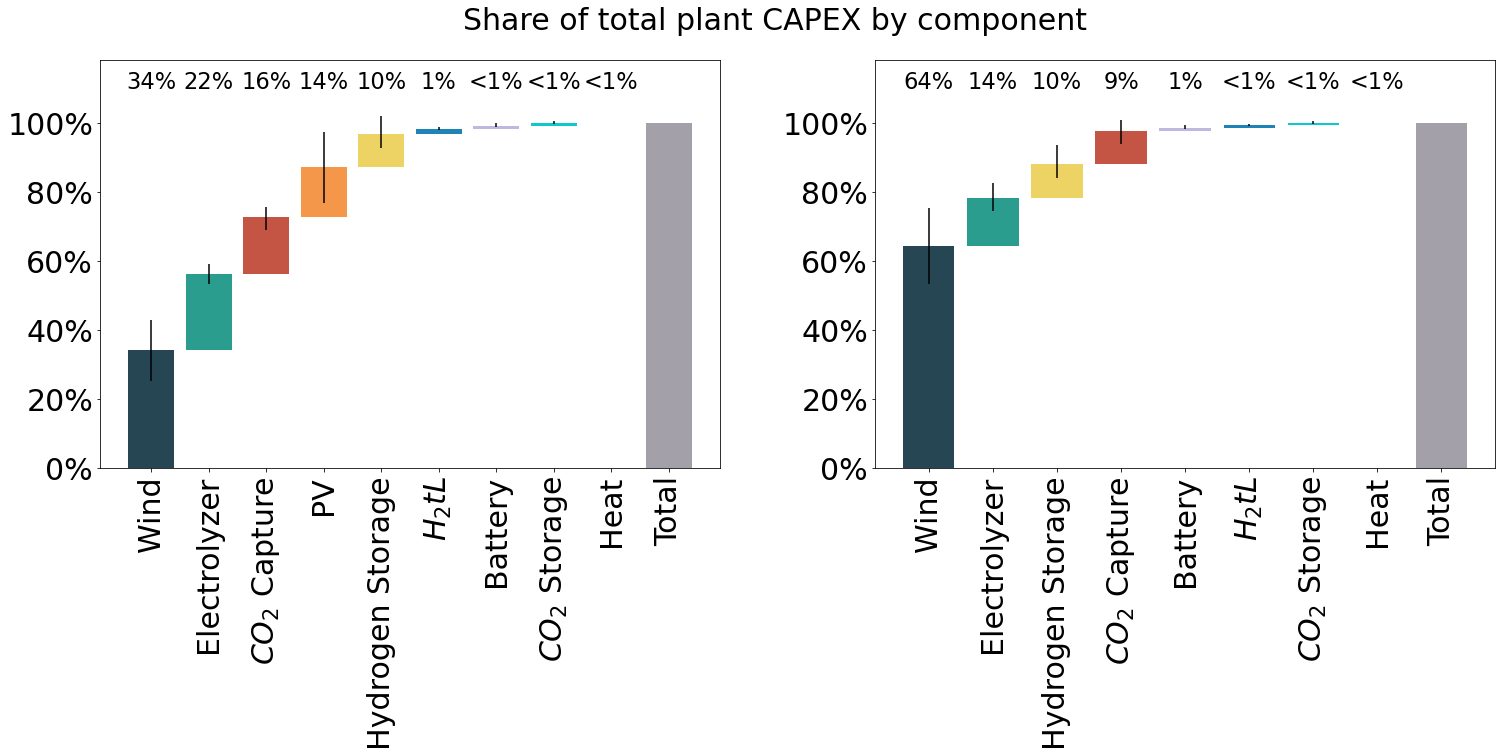

In [62]:
fig,axes = plt.subplots(ncols=2, figsize=(25,7.5))
fontsize = 30

for i,shore_designation,cols in zip([0,1],['onshore','offshore'],[onshore_npv_cols,offshore_npv_cols]):
    npv_share = costs_df.loc[costs_df['shore_designation']==shore_designation,cols]
    for col in npv_share.columns:
        npv_share[col] = npv_share[col]/npv_share['verify_NPV']
    npv_share = npv_share.describe(percentiles=[0.05,0.5,0.95]).T * 100

    npv_share_cumsum = npv_share.cumsum()
    npv_share_cumsum.iloc[-1] = npv_share.iloc[-1]
    npv_share_cumsum_mask = npv_share_cumsum.shift()
    npv_share_cumsum_mask.iloc[-1] = 0



    yerr1 = npv_share['mean'] - npv_share['5%']
    yerr2 = npv_share['95%'] - npv_share['mean']
    axes[i].bar(npv_share_cumsum.index.map(col_name_map), npv_share_cumsum['mean'], yerr=[yerr1,yerr2], color=npv_share_cumsum.index.map(colormap))
    axes[i].bar(npv_share_cumsum_mask.index.map(col_name_map), npv_share_cumsum_mask['mean'], color='white')
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(90)

    axes[i].set_ylim(0,118)
    # axes[0].set_ylim(0,110)
    for j,comp_share in enumerate(npv_share['mean'].iloc[:-1]):
        if comp_share<1:
            text = '<1%'
        else:
            text = f'{comp_share:.0f}%'
        axes[i].annotate(text, (j,110), fontsize=fontsize*0.75, ha='center')
    axes[i].tick_params(labelsize=fontsize)
    
#     axes[i].yaxis.set_ticks(axes[i].get_yticks()) # This line is only intended to supress a warning resulting from the following
    axes[i].set_yticklabels([f'{x:.0f}%' for x in axes[i].get_yticks()])

fig.suptitle('Share of total plant CAPEX by component', fontsize=fontsize)
plt.subplots_adjust(hspace=0,wspace=0.25)
# plt.tight_layout()
plt.savefig('../../gfx/cost_share.png', bbox_inches='tight', dpi=400)

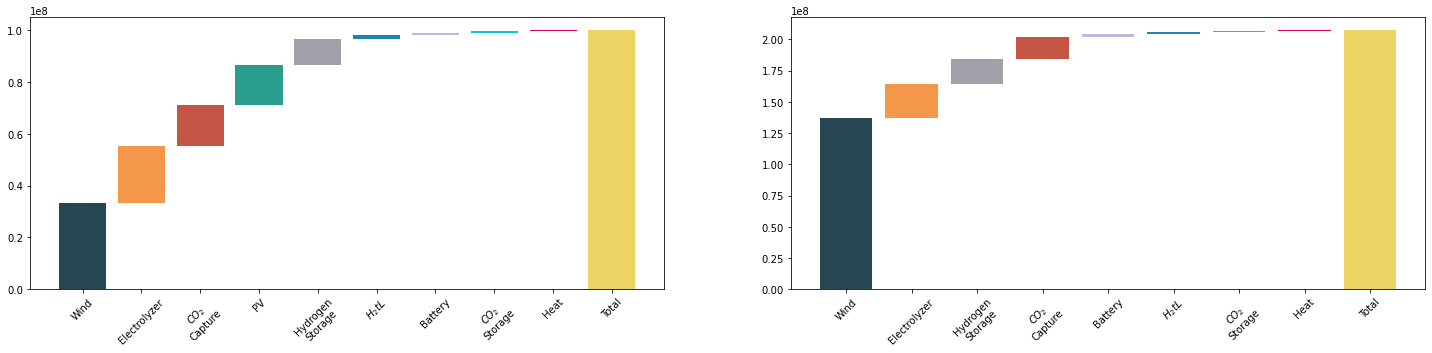

In [34]:
onshore_npv_summary = costs_df.loc[costs_df['shore_designation']=='onshore',onshore_npv_cols].describe(percentiles=[0.05,0.5,0.95]).T
onshore_npv_cumsum = onshore_npv_summary.cumsum()
onshore_npv_cumsum.iloc[-1] = onshore_npv_summary.iloc[-1]
onshore_npv_cumsum_mask = onshore_npv_cumsum.shift()
onshore_npv_cumsum_mask.iloc[-1] = 0

fig,axes = plt.subplots(ncols=2, figsize=(25,5))

axes[0].bar(onshore_npv_cumsum.index.map(col_name_map), onshore_npv_cumsum['mean'], color=onshore_npv_cumsum.index.map(colormap))
axes[0].bar(onshore_npv_cumsum_mask.index.map(col_name_map), onshore_npv_cumsum_mask['mean'], color='white')
for tick in axes[0].get_xticklabels():
    tick.set_rotation(45)
    
offshore_npv_summary = costs_df.loc[costs_df['shore_designation']=='offshore',offshore_npv_cols].describe(percentiles=[0.05,0.5,0.95]).T
offshore_npv_cumsum = offshore_npv_summary.cumsum()
offshore_npv_cumsum.iloc[-1] = offshore_npv_summary.iloc[-1]
offshore_npv_cumsum_mask = offshore_npv_cumsum.shift()
offshore_npv_cumsum_mask.iloc[-1] = 0


axes[1].bar(offshore_npv_cumsum.index.map(col_name_map), offshore_npv_cumsum['mean'], color=offshore_npv_cumsum.index.map(colormap))
axes[1].bar(offshore_npv_cumsum_mask.index.map(col_name_map), offshore_npv_cumsum_mask['mean'], color='white')
for ax in axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    